In [25]:
!pip install pycaret[full]

In [1]:
from google.colab import userdata
import json

# Get the Kaggle credentials from Colab's userdata
username = userdata.get("KAGGLE_USER")
key = userdata.get("KAGGLE_KEY")

# Echo the credentials into the kaggle.json file
!mkdir -p ~/.kaggle
!echo '{{"username":"{username}","key":"{key}"}}' > ~/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json

In [2]:
! kaggle competitions download -c network-attack-detection
! mkdir network-attack-detection
! unzip /content/network-attack-detection.zip -d network-attack-detection

  0% 0.00/4.26M [00:00<?, ?B/s]
100% 4.26M/4.26M [00:00<00:00, 52.2MB/s]
Archive:  /content/network-attack-detection.zip
  inflating: network-attack-detection/Sample_submission.csv  
  inflating: network-attack-detection/test.csv  
  inflating: network-attack-detection/train.csv  


## Overview

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_csv('/content/network-attack-detection/train.csv', index_col='id')
df = df.drop(columns=['id.orig_p', 'id.resp_p', 'service'])  # drop service because test_df doesn't have service info
print(df.shape)
df.head()

(61558, 81)


,proto,flow_duration,fwd_pkts_tot,bwd_pkts_tot,fwd_data_pkts_tot,bwd_data_pkts_tot,fwd_pkts_per_sec,bwd_pkts_per_sec,flow_pkts_per_sec,down_up_ratio,...,active.std,idle.min,idle.max,idle.tot,idle.avg,idle.std,fwd_init_window_size,bwd_init_window_size,fwd_last_window_size,Attack_type
id,,,,,,,,,,,,,,,,,,,,,
0,udp,0.020938,2,2,2,2,95.519386,95.519386,191.038772,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,Thing_Speak
1,tcp,0.000004,1,1,1,0,246723.764700,246723.764700,493447.529400,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,64,0,64,DOS_SYN_Hping
2,tcp,0.000004,1,1,1,0,262144.000000,262144.000000,524288.000000,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,64,0,64,DOS_SYN_Hping
3,udp,0.000000,1,0,1,0,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,ARP_poisioning
4,tcp,0.000006,1,1,0,0,167772.160000,167772.160000,335544.320000,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1024,0,1024,NMAP_OS_DETECTION


In [4]:
for col in df.select_dtypes('object'):
    print(f'{col}: {df[col].unique()}')

proto: ['udp' 'tcp' 'icmp']
Attack_type: ['Thing_Speak' 'DOS_SYN_Hping' 'ARP_poisioning' 'NMAP_OS_DETECTION'
 'NMAP_UDP_SCAN' 'NMAP_XMAS_TREE_SCAN' 'DDOS_Slowloris' 'NMAP_TCP_scan'
 'MQTT_Publish' 'Wipro_bulb' 'Metasploit_Brute_Force_SSH' 'NMAP_FIN_SCAN']


In [5]:
mask = df.isnull().sum()
mask[ mask > 0 ]

,0


## Data Cleansing
- view importance features before impute

In [10]:
from sklearn.ensemble import RandomForestClassifier

X = df.drop('Attack_type', axis=1)
y = df['Attack_type']

clf = RandomForestClassifier(random_state=42)
clf.fit(X, y)

importances = clf.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances}).sort_values('Importance', ascending=False)
top10_feature = feature_importance_df.head(10)
filtered_features = top10_feature['Feature'].tolist()
top10_feature

,Feature,Importance
29,fwd_pkts_payload.avg,0.088108
26,fwd_pkts_payload.min,0.082233
27,fwd_pkts_payload.max,0.076495
59,fwd_subflow_bytes,0.073651
53,flow_iat.tot,0.039117
28,fwd_pkts_payload.tot,0.036048
51,flow_iat.min,0.031809
52,flow_iat.max,0.028305
39,flow_pkts_payload.avg,0.028229
54,flow_iat.avg,0.027645


In [8]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
label_dict = le.fit(df["Attack_type"]).classes_  # Convert NaN to string before encoding
label_dict = dict(zip(label_dict, le.transform(label_dict)))
print(label_dict)

{'ARP_poisioning': 0, 'DDOS_Slowloris': 1, 'DOS_SYN_Hping': 2, 'MQTT_Publish': 3, 'Metasploit_Brute_Force_SSH': 4, 'NMAP_FIN_SCAN': 5, 'NMAP_OS_DETECTION': 6, 'NMAP_TCP_scan': 7, 'NMAP_UDP_SCAN': 8, 'NMAP_XMAS_TREE_SCAN': 9, 'Thing_Speak': 10, 'Wipro_bulb': 11}


In [9]:
proto_map = {'tcp': 0, 'udp': 1, 'icmp': 2}

df['proto'] = df['proto'].map(proto_map)
df['Attack_type'] = df['Attack_type'].map(label_dict)
df.head()

,proto,flow_duration,fwd_pkts_tot,bwd_pkts_tot,fwd_data_pkts_tot,bwd_data_pkts_tot,fwd_pkts_per_sec,bwd_pkts_per_sec,flow_pkts_per_sec,down_up_ratio,...,active.std,idle.min,idle.max,idle.tot,idle.avg,idle.std,fwd_init_window_size,bwd_init_window_size,fwd_last_window_size,Attack_type
id,,,,,,,,,,,,,,,,,,,,,
0,1,0.020938,2,2,2,2,95.519386,95.519386,191.038772,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,10
1,0,0.000004,1,1,1,0,246723.764700,246723.764700,493447.529400,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,64,0,64,2
2,0,0.000004,1,1,1,0,262144.000000,262144.000000,524288.000000,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,64,0,64,2
3,1,0.000000,1,0,1,0,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0
4,0,0.000006,1,1,0,0,167772.160000,167772.160000,335544.320000,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1024,0,1024,6


In [11]:
train_df = pd.concat([df['proto'], df[filtered_features], df['Attack_type']], axis=1)
train_df.head()

,proto,fwd_pkts_payload.avg,fwd_pkts_payload.min,fwd_pkts_payload.max,fwd_subflow_bytes,flow_iat.tot,fwd_pkts_payload.tot,flow_iat.min,flow_iat.max,flow_pkts_payload.avg,flow_iat.avg,Attack_type
id,,,,,,,,,,,,
0,1,36.0,36,36,72.0,20938.158040,72,264.883041,19657.135010,44.0,6979.386012,10
1,0,120.0,120,120,120.0,4.053116,120,4.053116,4.053116,60.0,4.053116,2
2,0,120.0,120,120,120.0,3.814697,120,3.814697,3.814697,60.0,3.814697,2
3,1,50.0,50,50,50.0,0.000000,50,0.000000,0.000000,50.0,0.000000,0
4,0,0.0,0,0,0.0,5.960464,0,5.960464,5.960464,0.0,5.960464,6


## Model selection

In [12]:
from pycaret.classification import *
import torch

In [14]:
clf_setup = setup(train_df, target='Attack_type', session_id=42, use_gpu=torch.cuda.is_available())
best_model = compare_models(sort='Accuracy', include=['dt', 'rf', 'xgboost',])
best_model = create_model(best_model)

,Description,Value
0,Session id,42
1,Target,Attack_type
2,Target type,Multiclass
3,Original data shape,"(61558, 12)"
4,Transformed data shape,"(61558, 12)"
5,Transformed train set shape,"(43090, 12)"
6,Transformed test set shape,"(18468, 12)"
7,Numeric features,11
8,Preprocess,True
9,Imputation type,simple


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.9742,0.9993,0.9742,0.9741,0.9728,0.9352,0.9354,1.6260
xgboost,Extreme Gradient Boosting,0.9733,0.9996,0.9733,0.9724,0.9714,0.9330,0.9331,3.6150
dt,Decision Tree Classifier,0.9730,0.9970,0.9730,0.9729,0.9717,0.9323,0.9325,1.0070


Processing:   0%|          | 0/17 [00:00<?, ?it/s]

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9717,0.9991,0.9717,0.9717,0.9706,0.9289,0.9291
1,0.9733,0.9991,0.9733,0.9732,0.9726,0.9330,0.9331
2,0.9747,0.9992,0.9747,0.9747,0.9739,0.9365,0.9366
3,0.9759,0.9997,0.9759,0.9770,0.9735,0.9394,0.9397
4,0.9754,0.9993,0.9754,0.9752,0.9748,0.9383,0.9383
5,0.9756,0.9993,0.9756,0.9753,0.9750,0.9388,0.9389
6,0.9740,0.9995,0.9740,0.9742,0.9733,0.9348,0.9349
7,0.9742,0.9992,0.9742,0.9723,0.9718,0.9353,0.9355
8,0.9747,0.9994,0.9747,0.9759,0.9729,0.9365,0.9367


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [15]:
evaluate_model(best_model)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

## Submission

In [16]:
test_df = pd.read_csv('/content/network-attack-detection/test.csv', index_col='id')
test_df = test_df.drop(columns=['id.orig_p', 'id.resp_p', 'service', 'Attack_type'])
test_df['proto'] = test_df['proto'].map(proto_map)
print(test_df.shape)
test_df.head()

(61559, 80)


,proto,flow_duration,fwd_pkts_tot,bwd_pkts_tot,fwd_data_pkts_tot,bwd_data_pkts_tot,fwd_pkts_per_sec,bwd_pkts_per_sec,flow_pkts_per_sec,down_up_ratio,...,active.avg,active.std,idle.min,idle.max,idle.tot,idle.avg,idle.std,fwd_init_window_size,bwd_init_window_size,fwd_last_window_size
id,,,,,,,,,,,,,,,,,,,,,
0,0,0.000005,1,1,1,0,199728.76190,199728.76190,3.994575e+05,1.0,...,5.006790,0.0,0.0,0.0,0.0,0.0,0.0,64,0,64
1,0,0.000001,1,1,1,0,838860.80000,838860.80000,1.677722e+06,1.0,...,1.192093,0.0,0.0,0.0,0.0,0.0,0.0,64,0,64
2,0,0.000004,1,1,1,0,246723.76470,246723.76470,4.934475e+05,1.0,...,4.053116,0.0,0.0,0.0,0.0,0.0,0.0,64,0,64
3,0,0.000005,1,1,1,0,199728.76190,199728.76190,3.994575e+05,1.0,...,5.006790,0.0,0.0,0.0,0.0,0.0,0.0,64,0,64
4,0,0.000011,1,1,0,0,91180.52174,91180.52174,1.823610e+05,1.0,...,10.967255,0.0,0.0,0.0,0.0,0.0,0.0,1024,0,1024


In [17]:
traceback = {}
for key, val in label_dict.items():
    traceback[val] = key
print(traceback)

{0: 'ARP_poisioning', 1: 'DDOS_Slowloris', 2: 'DOS_SYN_Hping', 3: 'MQTT_Publish', 4: 'Metasploit_Brute_Force_SSH', 5: 'NMAP_FIN_SCAN', 6: 'NMAP_OS_DETECTION', 7: 'NMAP_TCP_scan', 8: 'NMAP_UDP_SCAN', 9: 'NMAP_XMAS_TREE_SCAN', 10: 'Thing_Speak', 11: 'Wipro_bulb'}


In [18]:
test_prep = pd.concat([test_df['proto'], test_df[filtered_features],], axis=1)
test_prep.head()

,proto,fwd_pkts_payload.avg,fwd_pkts_payload.min,fwd_pkts_payload.max,fwd_subflow_bytes,flow_iat.tot,fwd_pkts_payload.tot,flow_iat.min,flow_iat.max,flow_pkts_payload.avg,flow_iat.avg
id,,,,,,,,,,,
0,0,120.0,120,120,120.0,5.006790,120,5.006790,5.006790,60.0,5.006790
1,0,120.0,120,120,120.0,1.192093,120,1.192093,1.192093,60.0,1.192093
2,0,120.0,120,120,120.0,4.053116,120,4.053116,4.053116,60.0,4.053116
3,0,120.0,120,120,120.0,5.006790,120,5.006790,5.006790,60.0,5.006790
4,0,0.0,0,0,0.0,10.967255,0,10.967255,10.967255,0.0,10.967255


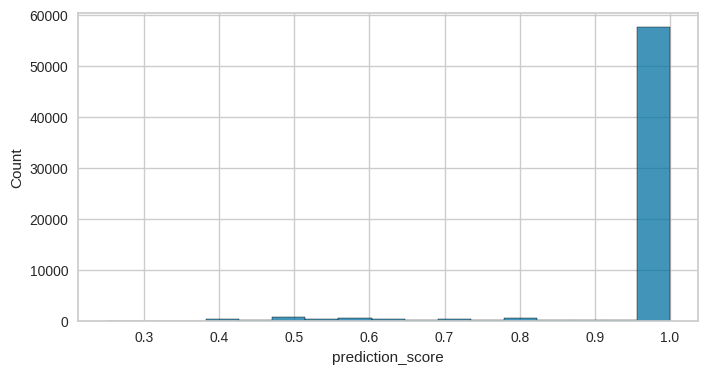

In [21]:
y_pred = predict_model(best_model, test_df)

plt.figure(figsize=(8, 4))
sns.histplot(y_pred['prediction_score']);

## Submission

In [25]:
submission = pd.read_csv('/content/network-attack-detection/Sample_submission.csv')
submission['Attack_type'] = y_pred['prediction_label'].map(traceback)
submission.head()

,id,Attack_type
0,0,DOS_SYN_Hping
1,1,DOS_SYN_Hping
2,2,DOS_SYN_Hping
3,3,DOS_SYN_Hping
4,4,NMAP_TCP_scan


In [26]:
submission.to_csv('rf_1.csv', index=False)